# Intermittent Math Modelling

This notebook focuses on mathematical modeling of intermittent treatment data for cancer cell growth dynamics.
Data is extracted from the organized processed datasets with exact seeding densities (20k and 30k).

In [1]:
# Essential packages for intermittent treatment modeling should only run once per project
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("DifferentialEquations")
Pkg.add("Optimization")
Pkg.add("OptimizationOptimJL")
Pkg.add("OptimizationBBO")
Pkg.add("DiffEqParamEstim")
Pkg.add("StatsBase")
Pkg.add("SciMLSensitivity")
Pkg.add("BlackBoxOptim")
Pkg.add("StatsPlots")
Pkg.add("DataFramesMeta")
Pkg.add("Interact")
Pkg.add("Random")
Pkg.add("Distributions")

    Updating registry at `C:\Users\MainFrameTower\.julia\registries\General.toml`
   Resolving package versions...
   Installed IteratorInterfaceExtensions ─ v1.0.0
   Installed DataAPI ───────────────────── v1.16.0
   Installed SentinelArrays ────────────── v1.4.8
   Installed PooledArrays ──────────────── v1.4.3
   Installed InlineStrings ─────────────── v1.4.5
   Installed TableTraits ───────────────── v1.0.1
   Installed Tables ────────────────────── v1.12.1
   Installed IteratorInterfaceExtensions ─ v1.0.0
   Installed DataAPI ───────────────────── v1.16.0
   Installed SentinelArrays ────────────── v1.4.8
   Installed PooledArrays ──────────────── v1.4.3
   Installed InlineStrings ─────────────── v1.4.5
   Installed TableTraits ───────────────── v1.0.1
   Installed Tables ────────────────────── v1.12.1
   Installed DataValueInterfaces ───────── v1.0.0
   Installed DataValueInterfaces ───────── v1.0.0
   Installed Compat ────────────────────── v4.18.0
   Installed Compat ──────────

In [63]:
using CSV
using DataFrames
using Plots
using DifferentialEquations
using Optimization, OptimizationOptimJL, OptimizationBBO
using BlackBoxOptim
using StatsBase
using Random
using Distributions
using Printf
using Statistics

In [64]:
# Core modeling functions
function setUpProblem(modelTypeSet, xdataSet, ydataSet, solverSet, u0Set, pSet, tspanSet, boundsSet)
    best_params, best_sol, best_prob, best_loss = nothing, nothing, nothing, Inf

    for _ in 1:5
        p_init = [lo[1] == lo[2] ? lo[1] : rand(Uniform(lo[1], lo[2])) for lo in boundsSet]

        try
            prob = ODEProblem(modelTypeSet, u0Set, tspanSet, p_init)
            loss_func = build_loss_objective(prob, solverSet, L2Loss(xdataSet, ydataSet), Optimization.AutoForwardDiff())
            result = bboptimize(loss_func; SearchRange=boundsSet, MaxTime=30.0, TraceMode=:silent)
            p_opt = best_candidate(result)
            sol = solve(remake(prob, p=p_opt), solverSet, saveat=xdataSet)
            loss = sum(abs2.(ydataSet .- [u[1] for u in sol.u]))

            if loss < best_loss
                best_params, best_sol, best_prob, best_loss = p_opt, sol, prob, loss
            end
        catch; end
    end

    return best_params, best_sol, best_prob
end

function calculate_bic(probbic, xdatabic, ydatabic, solverbic, optparbic)
    solbic = solve(probbic, solverbic, reltol=1e-15, abstol=1e-15, saveat=xdatabic)
    residualsbic = [ydatabic[i] - solbic(xdatabic[i])[1] for i in 1:length(xdatabic)]
    ssrbic = sum(residualsbic .^ 2)
    kbic = length(optparbic)
    nbic = length(xdatabic)
    bic = nbic * log(ssrbic / nbic) + kbic * log(nbic)
    return bic, ssrbic
end

function plot_model_fit(x, y, optimized_params, optimized_sol, bic, ssr, title_str)
    println("\nOptimized Parameters: ", round.(optimized_params, digits=4))
    println("Sum of Squared Residuals (SSR): ", round(ssr, digits=6))
    println("Bayesian Information Criterion (BIC): ", round(bic, digits=2))
    
    p = plot(x, y, label="Data", legend=:bottomright, title=title_str, xlabel="Day", ylabel="Cell Count", 
             lw=2, marker=:circle, markersize=4)
    plot!(optimized_sol.t, [u[1] for u in optimized_sol.u], label="Model", lw=3, linestyle=:dash)
    
    display(p)
    return p
end

plot_model_fit (generic function with 1 method)

In [65]:
# Load intermittent data from processed datasets
function load_intermittent_data(seeding_density::String)
    base_path = "Processed_Datasets/Intermittent Data/$(seeding_density)_seeding_density/Averages/"
    
    # Define file mappings
    files = [
        "A2780T_dayaverages.csv",     # Naive treated
        "A2780UT_dayaverages.csv",    # Naive untreated  
        "A2780cisT_dayaverages.csv",  # Resistant treated
        "A2780cisUT_dayaverages.csv"  # Resistant untreated
    ]
    
    datasets = Dict{String, DataFrame}()
    
    for file in files
        try
            df = CSV.read(base_path * file, DataFrame)
            datasets[file] = df
            println("✅ Loaded: ", file, " ($(nrow(df)) rows)")
        catch e
            println("❌ Failed to load: $file")
            println("   ↳ Error: ", e)
        end
    end
    
    return datasets
end

# Extract x,y data from day averages CSV (data is already preprocessed)
function extract_xy_from_dayaverages(df::DataFrame)
    # Extract day and cell count data from preprocessed CSV
    x = Float64.(df[:, 1])  # First column (days)
    y = Float64.(df[:, 2])  # Second column (cell counts) - already processed
    
    println("   → Data range: Day $(x[1])-$(x[end]), Cell count $(minimum(y))-$(maximum(y))")
    return x, y
end

extract_xy_from_dayaverages (generic function with 1 method)

In [66]:
# Mathematical models for intermittent treatment

# 1. Standard logistic growth (for comparison)
function logistic_growth!(du, u, p, t)
    r, K = p
    du[1] = r * u[1] * (1 - u[1] / K)
end

# 2. Early treatment with lingering decay (T files: treated 0-7, untreated 7-14)
function early_treatment_decay!(du, u, p, t)
    r, K, drug_effect, decay_rate = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment (days 0-7): full drug effect
        current_drug_effect = drug_effect
    else
        # Post-treatment (days 7-14): exponential decay of lingering effect
        time_since_treatment = t - treatment_end
        current_drug_effect = drug_effect * exp(-time_since_treatment / decay_rate)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 3. Late treatment (UT files: untreated 0-7, treated 7-14)
function late_treatment!(du, u, p, t)
    r, K, drug_effect = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment (days 0-7): no drug effect
        current_drug_effect = 0.0
    else
        # During treatment (days 7-14): full drug effect
        current_drug_effect = drug_effect
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 4. Early treatment with biphasic decay (fast + slow clearance)
function early_treatment_biphasic!(du, u, p, t)
    r, K, drug_effect, fast_decay, slow_decay, fast_fraction = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: full effect
        current_drug_effect = drug_effect
    else
        # Post-treatment: biphasic decay
        time_since_end = t - treatment_end
        fast_component = fast_fraction * exp(-time_since_end / fast_decay)
        slow_component = (1 - fast_fraction) * exp(-time_since_end / slow_decay)
        current_drug_effect = drug_effect * (fast_component + slow_component)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 5. Early treatment with power law decay (very persistent effects)
function early_treatment_powerlaw!(du, u, p, t)
    r, K, drug_effect, decay_exponent, time_scale = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: full effect
        current_drug_effect = drug_effect
    else
        # Post-treatment: power law decay
        time_since_end = t - treatment_end
        current_drug_effect = drug_effect / (1 + (time_since_end / time_scale)^decay_exponent)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 6. Late treatment with immediate effect buildup
function late_treatment_buildup!(du, u, p, t)
    r, K, drug_effect, buildup_rate = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment: no effect
        current_drug_effect = 0.0
    else
        # During treatment: gradual buildup to full effect
        time_in_treatment = t - treatment_start
        current_drug_effect = drug_effect * (1 - exp(-time_in_treatment / buildup_rate))
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 7. Early treatment with Hill effect (T files: treated 0-7, untreated 7-14)
function early_treatment_hill!(du, u, p, t)
    r, K, max_drug_effect, hill_coeff, half_effect_time = p
    N = u[1]
    
    treatment_end = 7.0
    if t <= treatment_end
        # During treatment: Hill function increases effect over time
        current_drug_effect = max_drug_effect * (t^hill_coeff) / (t^hill_coeff + half_effect_time^hill_coeff)
    else
        # Post-treatment: no drug effect (immediate clearance)
        current_drug_effect = 0.0
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

# 8. Late treatment with Hill effect (UT files: untreated 0-7, treated 7-14)
function late_treatment_hill!(du, u, p, t)
    r, K, max_drug_effect, hill_coeff, half_effect_time = p
    N = u[1]
    
    treatment_start = 7.0
    if t <= treatment_start
        # Pre-treatment: no drug effect
        current_drug_effect = 0.0
    else
        # During treatment: Hill function increases effect over time in treatment
        time_in_treatment = t - treatment_start
        current_drug_effect = max_drug_effect * (time_in_treatment^hill_coeff) / (time_in_treatment^hill_coeff + half_effect_time^hill_coeff)
    end
    
    effective_growth_rate = r * (1 - current_drug_effect)
    du[1] = effective_growth_rate * N * (1 - N / K)
end

late_treatment_hill! (generic function with 1 method)

Loading 20k seeding density data...
✅ Loaded: A2780T_dayaverages.csv (14 rows)
✅ Loaded: A2780UT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisUT_dayaverages.csv (14 rows)

📊 Processing: A2780cisT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 84.95524691358025-4098.231018518519
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


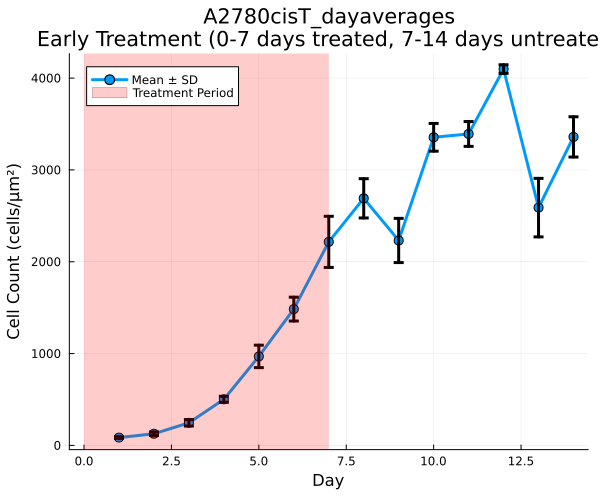


📊 Processing: A2780T_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 164.70011574074073-2859.6863425925926
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


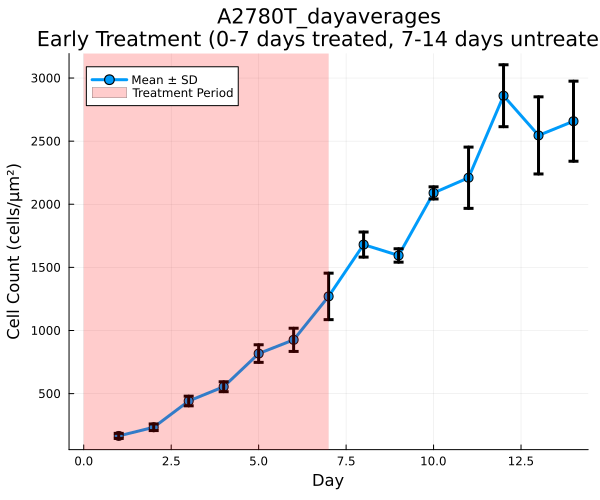


📊 Processing: A2780cisUT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 43.80231481481482-3813.640779320988
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


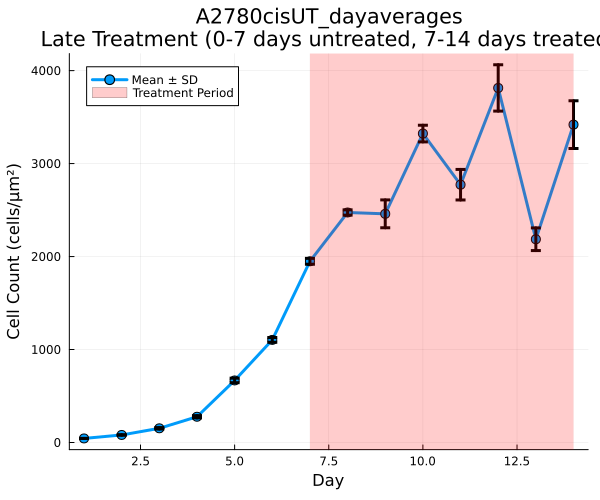


📊 Processing: A2780UT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 70.98599537037036-3088.9737268518525
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


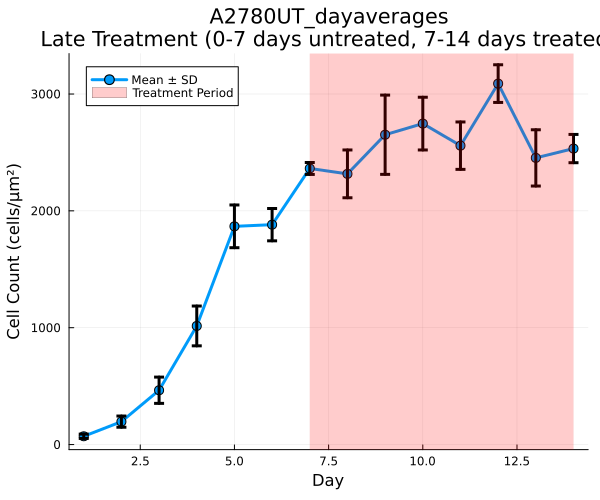


📈 Displaying combined overview for 20k seeding density...


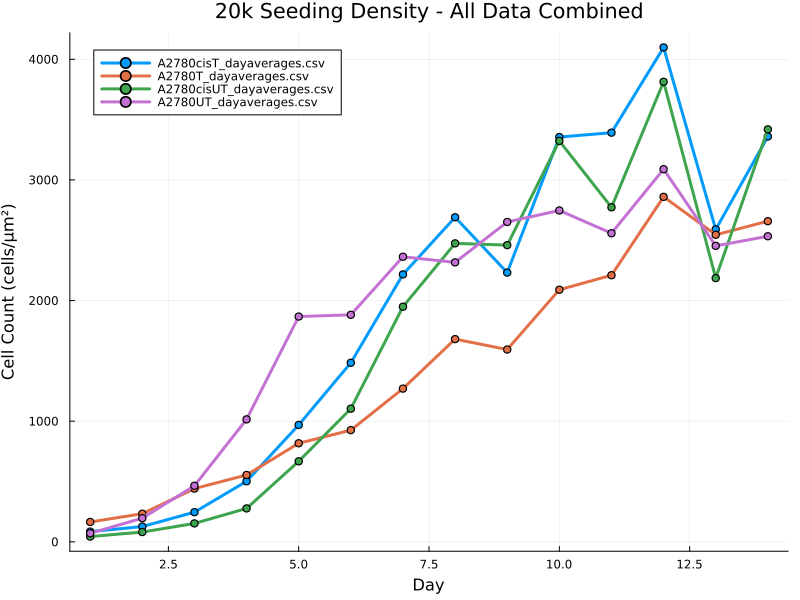


📊 Displaying treatment-specific combined plots...


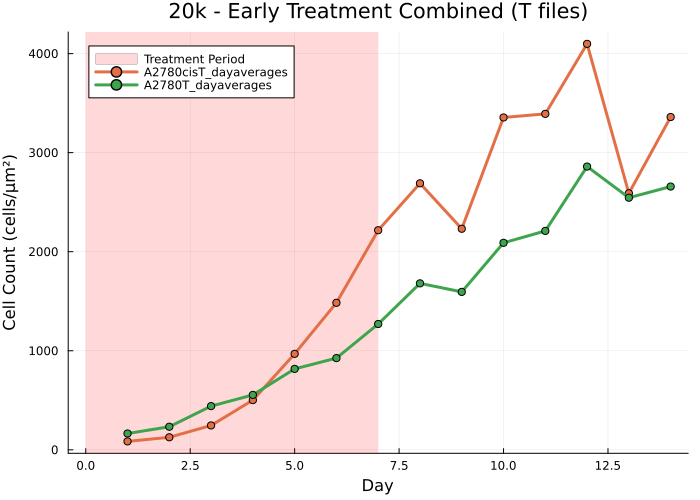

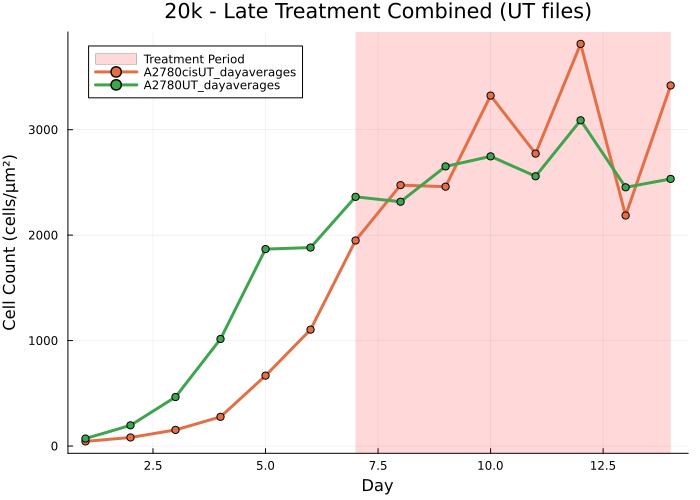

In [71]:
# Load and analyze 20k seeding density data
println("Loading 20k seeding density data...")
datasets_20k = load_intermittent_data("20k")

# Initialize storage for results
results_20k = Dict{String, Any}()
xy_data_20k = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()

# Create combined overview plot
plot_all_combined = plot(title="20k Seeding Density - All Data Combined", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(800, 600))

# Process each dataset and create individual plots with error bars
for (filename, df) in datasets_20k
    println("\n📊 Processing: $filename")
    
    # Extract data including error information
    days = Float64.(df[:, 1])  # Day column
    mean_counts = Float64.(df[:, 2])  # Mean_Cells_um2 column
    std_devs = Float64.(df[:, 3])  # Std_Dev_um2 column
    
    # Store x,y data for later use
    xy_data_20k[filename] = (days, mean_counts)
    
    # Add to combined plot
    plot!(plot_all_combined, days, mean_counts, label=filename, lw=3, marker=:circle, markersize=4)
    
    # Create individual plot with error bars
    cell_type = replace(filename, ".csv" => "")
    treatment_info = if occursin("T_", filename) && !occursin("UT_", filename)
        "Early Treatment (0-7 days treated, 7-14 days untreated)"
    elseif occursin("UT_", filename)
        "Late Treatment (0-7 days untreated, 7-14 days treated)"
    else
        "Unknown treatment pattern"
    end
    
    individual_plot = plot(
        title="$cell_type\n$treatment_info",
        xlabel="Day", 
        ylabel="Cell Count (cells/μm²)",
        legend=:topleft,
        size=(600, 500)
    )
    
    # Plot with error bars (using standard deviation)
    plot!(individual_plot, days, mean_counts, 
          yerror=std_devs,
          label="Mean ± SD", 
          lw=3, 
          marker=:circle, 
          markersize=5,
          capsize=3)
    
    # Add treatment period indicators
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment: shade 0-7 days
        vspan!(individual_plot, [0, 7], alpha=0.2, color=:red, label="Treatment Period")
    elseif occursin("UT_", filename)
        # Late treatment: shade 7-14 days
        vspan!(individual_plot, [7, 14], alpha=0.2, color=:red, label="Treatment Period")
    end
    
    println("   → Data range: Day $(days[1])-$(days[end]), Cell count $(minimum(mean_counts))-$(maximum(mean_counts))")
    println("   → Treatment type: $treatment_info")
    
    # Display individual plot
    display(individual_plot)
    
    # Store empty results since we're not doing model fitting
    results_20k[filename] = []
end

# Display combined overview plot
println("\n📈 Displaying combined overview for 20k seeding density...")
display(plot_all_combined)

# Create treatment-specific combined plots
plot_early_combined = plot(title="20k - Early Treatment Combined (T files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))
plot_late_combined = plot(title="20k - Late Treatment Combined (UT files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))

# Add treatment period shading
vspan!(plot_early_combined, [0, 7], alpha=0.15, color=:red, label="Treatment Period")
vspan!(plot_late_combined, [7, 14], alpha=0.15, color=:red, label="Treatment Period")

for (filename, df) in datasets_20k
    days = Float64.(df[:, 1])
    mean_counts = Float64.(df[:, 2])
    
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment files
        plot!(plot_early_combined, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    elseif occursin("UT_", filename)
        # Late treatment files  
        plot!(plot_late_combined, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    end
end

println("\n📊 Displaying treatment-specific combined plots...")
display(plot_early_combined)
display(plot_late_combined)


Loading 30k seeding density data...
✅ Loaded: A2780T_dayaverages.csv (14 rows)
✅ Loaded: A2780UT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisT_dayaverages.csv (14 rows)
✅ Loaded: A2780cisUT_dayaverages.csv (14 rows)

📊 Processing: A2780cisT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 107.89394290123457-4007.9396604938265
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


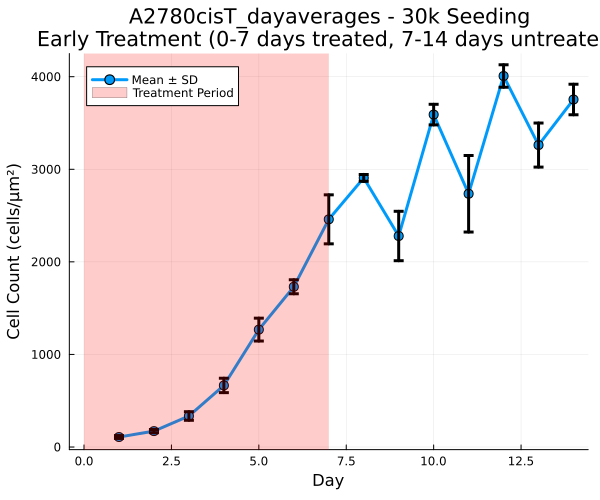


📊 Processing: A2780T_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 288.98688271604937-2716.687654320988
   → Treatment type: Early Treatment (0-7 days treated, 7-14 days untreated)


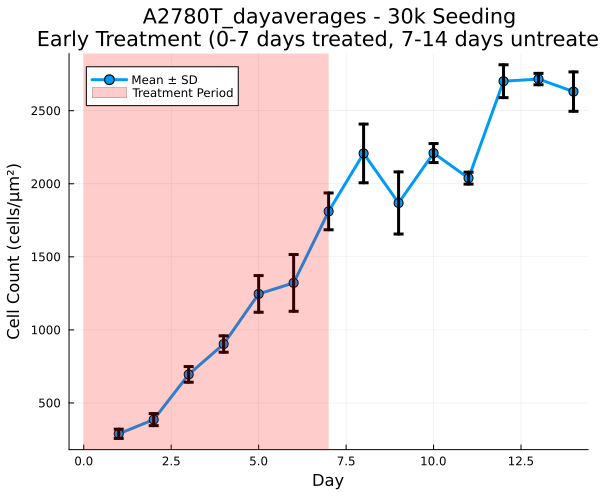


📊 Processing: A2780cisUT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 68.5091049382716-3735.9834104938273
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


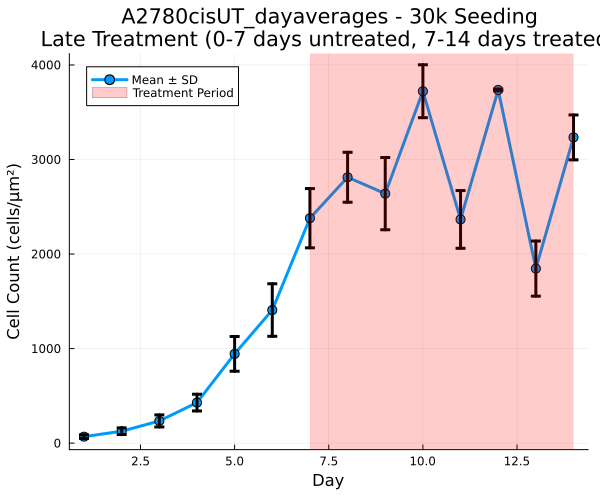


📊 Processing: A2780UT_dayaverages.csv
   → Data range: Day 1.0-14.0, Cell count 89.00717592592594-3023.571913580247
   → Treatment type: Late Treatment (0-7 days untreated, 7-14 days treated)


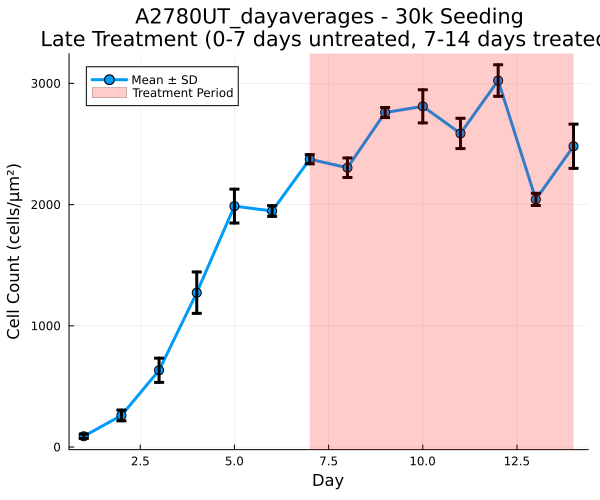


📈 Displaying combined overview for 30k seeding density...


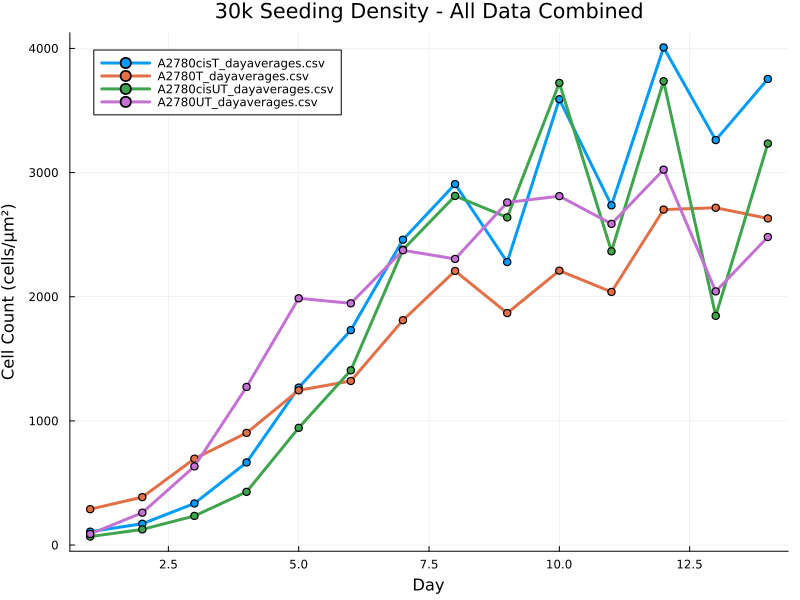


📊 Displaying treatment-specific combined plots...


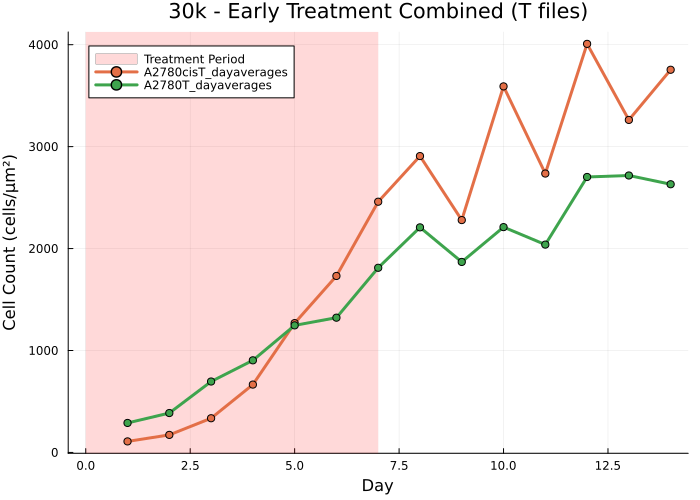

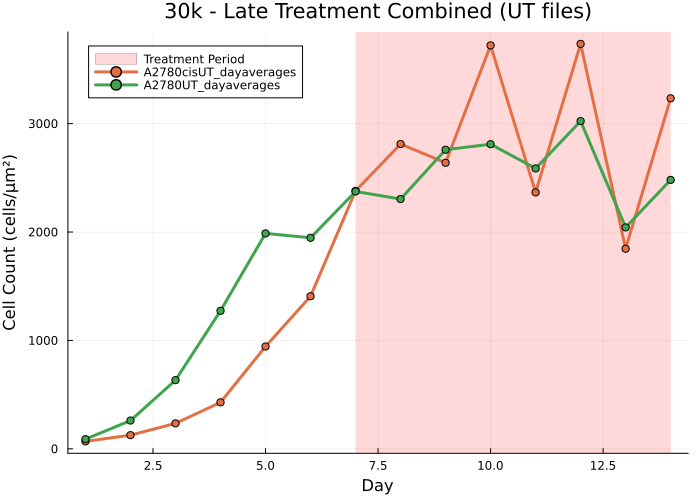

In [73]:
# Load and analyze 30k seeding density data
println("\nLoading 30k seeding density data...")
datasets_30k = load_intermittent_data("30k")

# Initialize storage for results
results_30k = Dict{String, Any}()
xy_data_30k = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()

# Create combined overview plot
plot_all_combined_30k = plot(title="30k Seeding Density - All Data Combined", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(800, 600))

# Process each dataset and create individual plots with error bars
for (filename, df) in datasets_30k
    println("\n📊 Processing: $filename")
    
    # Extract data including error information
    days = Float64.(df[:, 1])  # Day column
    mean_counts = Float64.(df[:, 2])  # Mean_Cells_um2 column
    std_devs = Float64.(df[:, 3])  # Std_Dev_um2 column
    
    # Store x,y data for later use
    xy_data_30k[filename] = (days, mean_counts)
    
    # Add to combined plot
    plot!(plot_all_combined_30k, days, mean_counts, label=filename, lw=3, marker=:circle, markersize=4)
    
    # Create individual plot with error bars
    cell_type = replace(filename, ".csv" => "")
    treatment_info = if occursin("T_", filename) && !occursin("UT_", filename)
        "Early Treatment (0-7 days treated, 7-14 days untreated)"
    elseif occursin("UT_", filename)
        "Late Treatment (0-7 days untreated, 7-14 days treated)"
    else
        "Unknown treatment pattern"
    end
    
    individual_plot = plot(
        title="$cell_type - 30k Seeding\n$treatment_info",
        xlabel="Day", 
        ylabel="Cell Count (cells/μm²)",
        legend=:topleft,
        size=(600, 500)
    )
    
    # Plot with error bars (using standard deviation)
    plot!(individual_plot, days, mean_counts, 
          yerror=std_devs,
          label="Mean ± SD", 
          lw=3, 
          marker=:circle, 
          markersize=5,
          capsize=3)
    
    # Add treatment period indicators
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment: shade 0-7 days
        vspan!(individual_plot, [0, 7], alpha=0.2, color=:red, label="Treatment Period")
    elseif occursin("UT_", filename)
        # Late treatment: shade 7-14 days
        vspan!(individual_plot, [7, 14], alpha=0.2, color=:red, label="Treatment Period")
    end
    
    println("   → Data range: Day $(days[1])-$(days[end]), Cell count $(minimum(mean_counts))-$(maximum(mean_counts))")
    println("   → Treatment type: $treatment_info")
    
    # Display individual plot
    display(individual_plot)
    
    # Store empty results since we're not doing model fitting
    results_30k[filename] = []
end

# Display combined overview plot
println("\n📈 Displaying combined overview for 30k seeding density...")
display(plot_all_combined_30k)

# Create treatment-specific combined plots
plot_early_combined_30k = plot(title="30k - Early Treatment Combined (T files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))
plot_late_combined_30k = plot(title="30k - Late Treatment Combined (UT files)", xlabel="Day", ylabel="Cell Count (cells/μm²)", legend=:topleft, size=(700, 500))

# Add treatment period shading
vspan!(plot_early_combined_30k, [0, 7], alpha=0.15, color=:red, label="Treatment Period")
vspan!(plot_late_combined_30k, [7, 14], alpha=0.15, color=:red, label="Treatment Period")

for (filename, df) in datasets_30k
    days = Float64.(df[:, 1])
    mean_counts = Float64.(df[:, 2])
    
    if occursin("T_", filename) && !occursin("UT_", filename)
        # Early treatment files
        plot!(plot_early_combined_30k, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    elseif occursin("UT_", filename)
        # Late treatment files  
        plot!(plot_late_combined_30k, days, mean_counts, 
              label=replace(filename, ".csv" => ""), 
              lw=3, marker=:circle, markersize=4)
    end
end

println("\n📊 Displaying treatment-specific combined plots...")
display(plot_early_combined_30k)
display(plot_late_combined_30k)

In [74]:
# ... rest of earlier cell code untouched ...

# Ultra-simple brute-force scan (patched success checking)
function ultra_simple_fit(data_x, data_y)
    println("        🎯 Ultra-simple logistic fitting...")
    x_shifted = data_x .- minimum(data_x)
    u0 = [max(1e-9, data_y[1])]
    tspan = (0.0, x_shifted[end])

    r_vals = [0.05, 0.1, 0.2, 0.3]
    K_vals = [maximum(data_y)*k for k in (1.2, 1.5, 2.0)]

    best = (ssr=Inf, r=NaN, K=NaN, pred=nothing)

    for r in r_vals, K in K_vals
        prob = ODEProblem(logistic_growth!, u0, tspan, [r, K])
        try
            sol = solve(prob, Tsit5(); saveat=x_shifted, abstol=1e-3, reltol=1e-3)
            if is_success(sol)
                pred = sol.(x_shifted) |> x -> getindex.(x, 1)
                ssr = sum((data_y .- pred).^2)
                if ssr < best.ssr
                    best = (ssr=ssr, r=r, K=K, pred=pred)
                end
            end
        catch
            # ignore
        end
    end

    if isfinite(best.ssr)
        return true, best
    else
        println("        ❌ All parameter combinations failed")
        return false, nothing
    end
end

# iterate files (existing code continues)

ultra_simple_fit (generic function with 1 method)

In [75]:
# === Patch: Robust retcode success checks and safer solve wrappers ===
# No new dependencies required

# Helper to determine if a solution is successful across SciML versions
is_success(sol) = try
    s = string(getproperty(sol, :retcode))
    # Accept explicit Success; extend if you want to treat Terminated as success
    occursin("Success", s)
catch
    false
end

# Safer solve that returns (ok, sol)
function safe_solve(prob; alg=Tsit5(), saveat=nothing, abstol=1e-3, reltol=1e-3)
    try
        if saveat === nothing
            sol = solve(prob, alg; abstol=abstol, reltol=reltol)
        else
            sol = solve(prob, alg; saveat=saveat, abstol=abstol, reltol=reltol)
        end
        return is_success(sol), sol
    catch e
        @warn "Solve threw exception" exception=e
        return false, nothing
    end
end

# Re-test a minimal logistic with robust checks
function test_logistic_fixed2(data_x, data_y)
    println("\n🧪 Testing FIXED logistic model (robust checks)...")

    x_shifted = data_x .- minimum(data_x)
    u0 = [max(1e-9, data_y[1])]
    tspan = (0.0, x_shifted[end])

    r_test = 0.2
    K_test = max(maximum(data_y) * 1.5, data_y[1] * 2)

    println("Initial condition: $u0, tspan=$tspan")
    println("Testing parameters: r=$r_test, K=$K_test")

    prob = ODEProblem(logistic_growth!, u0, tspan, [r_test, K_test])
    ok, sol = safe_solve(prob; alg=Tsit5(), saveat=x_shifted, abstol=1e-3, reltol=1e-3)

    if ok
        println("✅ ODE solution successful (robust check)")
        predicted = sol.(x_shifted)
        predicted = getindex.(predicted, 1)
        ssr = sum((data_y .- predicted) .^ 2)
        println("SSR: $ssr; lengths data=$(length(data_y)) pred=$(length(predicted))")
        return true, [r_test, K_test], sol, ssr, predicted
    else
        rc = (sol === nothing) ? :Exception : getproperty(sol, :retcode)
        println("❌ ODE not successful; retcode=$(rc)")
        return false, nothing, sol, Inf, nothing
    end
end

# Robust loss using the new check
function fixed_loss2(p, test_days, test_counts)
    r, K = p
    if !(isfinite(r) && isfinite(K)) || r <= 0 || K <= 0
        return 1e10
    end

    x_shifted = test_days .- minimum(test_days)
    u0 = [max(1e-9, test_counts[1])]
    tspan = (0.0, x_shifted[end])

    prob = ODEProblem(logistic_growth!, u0, tspan, [r, K])
    ok, sol = safe_solve(prob; alg=Tsit5(), abstol=1e-3, reltol=1e-3)
    if !ok
        return 1e10
    end

    pred = sol.(x_shifted)
    pred = getindex.(pred, 1)
    ssr = sum((test_counts .- pred) .^ 2)
    return isfinite(ssr) ? ssr : 1e10
end

# If the earlier variables exist in the session, try the new test quickly
try
    if @isdefined(test_days) && @isdefined(test_counts)
        success2, params2, sol2, ssr2, pred2 = test_logistic_fixed2(test_days, test_counts)
        println(success2 ? "✅ Robust check path succeeded" : "❌ Robust check path still failing")
    else
        println("ℹ️ Define test_days/test_counts first to auto-run the quick test.")
    end
catch e
    @warn "Quick re-test failed" exception=e
end


🧪 Testing FIXED logistic model (robust checks)...
Initial condition: [84.95524691358025], tspan=(0.0, 13.0)
Testing parameters: r=0.2, K=6147.346527777778
✅ ODE solution successful (robust check)
SSR: 5.1647310442153305e7; lengths data=14 pred=14
✅ Robust check path succeeded



🧪 One-shot test: Logistic fit on a single dataset
Using dataset: A2780cisT_dayaverages.csv
Days range: 1.0..14.0; Counts: 85.0..4098.2
✅ Best grid: r=0.25, K=10245.58, SSR=3.796371859e7



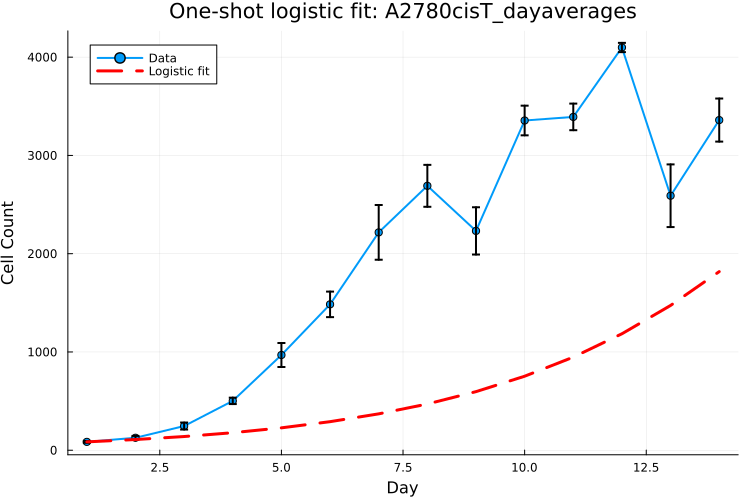

In [76]:
# === One-shot test: one dataset × one model × one plot ===
println("\n🧪 One-shot test: Logistic fit on a single dataset")

# Ensure data dictionary exists
if !@isdefined(datasets_20k) || isempty(datasets_20k)
    println("❌ datasets_20k is not defined or empty. Please run the data loading cells above.")
else
    # Choose a dataset key explicitly or fallback to first
    chosen_key = begin
        ks = collect(keys(datasets_20k))
        sel = filter(k -> occursin("A2780cisT", k) || occursin("A2780T", k), ks)
        isempty(sel) ? first(ks) : first(sel)
    end

    df = datasets_20k[chosen_key]
    days = Float64.(df[:, 1])
    counts = Float64.(df[:, 2])
    std_devs = size(df, 2) >= 3 ? Float64.(df[:, 3]) : fill(0.0, length(days))

    println("Using dataset: ", chosen_key)
    println("Days range: $(minimum(days))..$(maximum(days)); Counts: $(round(minimum(counts), digits=1))..$(round(maximum(counts), digits=1))")

    # Simple grid fit using safe_solve
    best_params = nothing
    best_sol = nothing
    best_ssr = Inf

    r_values = [0.05, 0.1, 0.15, 0.2, 0.25]
    K_factors = [1.2, 1.5, 2.0, 2.5]

    x_shifted = days .- minimum(days)
    u0 = [max(1e-9, counts[1])]
    tspan = (0.0, x_shifted[end])

    for r in r_values, Kfac in K_factors
        K = maximum(counts) * Kfac
        prob = ODEProblem(logistic_growth!, u0, tspan, [r, K])
        ok, sol = safe_solve(prob; alg=Tsit5(), saveat=x_shifted, abstol=1e-3, reltol=1e-3)
        if ok
            pred = sol.(x_shifted) |> x -> getindex.(x, 1)
            ssr = sum((counts .- pred) .^ 2)
            if isfinite(ssr) && ssr < best_ssr
                best_params, best_sol, best_ssr = [r, K], sol, ssr
            end
        end
    end

    if best_params === nothing
        println("❌ No successful grid candidate found.")
    else
        println("✅ Best grid: r=$(round(best_params[1], digits=4)), K=$(round(best_params[2], digits=2)), SSR=$(round(best_ssr, digits=2))")
        pred = best_sol.(x_shifted) |> x -> getindex.(x, 1)
        p = plot(title="One-shot logistic fit: $(replace(chosen_key, ".csv"=>""))", xlabel="Day", ylabel="Cell Count", legend=:topleft, size=(750, 500))
        plot!(p, days, counts, yerror=std_devs, label="Data", marker=:circle, lw=2, capsize=3)
        plot!(p, days, pred, label="Logistic fit", lw=3, linestyle=:dash, color=:red)
        display(p)
    end
end